# Image Normalization and quantative analysis of different color forms

**Different color forms**
1. RGB 
2. HSI
3. Lαβ

In [1]:
import cv2
import numpy as np 
from matplotlib import pyplot as plt
img = cv2.imread("Breast Cancer Cells/ytma10_010704_malignant2_ccd.tif")

In [2]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imshow('H and E stain',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
r,g,b= cv2.split(img)

# Method 1

**Trying the First Method for conversion Direst throught open cv (Failed ie it gave the same result that of bgr to rgb conversion**

In [4]:
rows, cols = (768, 896)
red =np.zeros( (768,896) , dtype=np.float64)
blue = np.zeros( (768,896) , dtype=np.float64)
green = np.zeros( (768,896) , dtype=np.float64)
red= r
green = g
blue = b

In [5]:
red= red/255
green = green/255
blue = blue/255
newimg=cv2.merge([red,green,blue])

In [6]:
normimg = cv2.normalize(newimg, None, alpha=1,beta=0.15, norm_type=cv2.NORM_MINMAX)
cv2.imshow('rgb Normalized',normimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
# now lets just try and normalize the image as per the instruction of a online weksite .
img.shape

(768, 896, 3)

# Method 2

**Macenko's Method in "A Method for Normalizing Histology Slides for Quantitative Analysis"**
* Refer the Paper for more help 
  http://wwwx.cs.unc.edu/~mn/sites/default/files/macenko2009.pdf

**Input: RGB image
Step 1: Convert RGB to OD**

**Step 2: Remove data with OD intensity less than β**

**Step 3: Calculate  singular value decomposition (SVD) on the OD tuples**

**Step 4: Create plane from the SVD directions corresponding to the
two largest singular values**

**Step 5: Project data onto the plane, and normalize to unit length**

**Step 6: Calculate angle of each point wrt the first SVD direction**

**Step 7: Find robust extremes (αth and (100−α)th 7 percentiles) of the
        angle**

**Step 8: Convert extreme values back to OD space**

**Output: Optimal Stain Vectors**


#  Normalization For RGB  Image

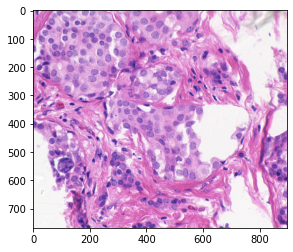

In [8]:
Io = 240       # Transmitted light intensity, Normalizing factor for image intensities
alpha = 1      #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
beta = 0.15    #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)
imgplot = plt.imshow(img)
plt.show()

In [9]:
# Step 1: Convert RGB to OD
# reference H&E OD matrix.

HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],                                  # default values. 
                  [0.4062, 0.5581]])
# reference maximum stain concentrations for H&E
maxCRef = np.array([1.9705, 1.0308])

# extract the height, width and num of channels of image
h, w, c = img.shape

# reshape image to multiple rows and 3 columns.
#Num of rows depends on the image size (wxh)
img = img.reshape((-1,3))


In [10]:
# calculate optical density
# OD = −log10(I)  
#OD = -np.log10(img+0.004)  #Use this when reading images with skimage
#Adding 0.004 just to avoid log of zero. 

OD = -np.log10((img.astype(np.float64)+1)/Io)    #Use this for opencv imread

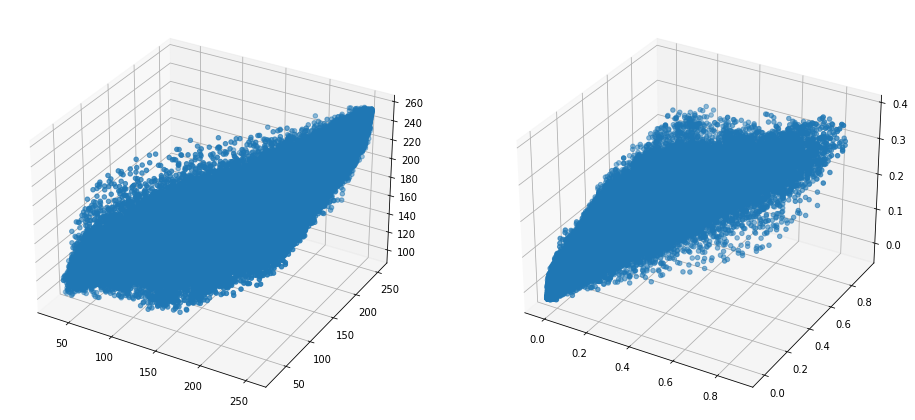

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(img[:,0],img[:,1],img[:,2])
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(OD[:,0],OD[:,1],OD[:,2])
plt.show()

In [12]:
# Step 2: Remove data with OD intensity less than β 
# remove transparent pixels (clear region with no tissue)s
ODhat = OD[~np.any(OD < beta, axis=1)]        #Returns an array where OD values are above beta

In [13]:
# Step 3: Calculate SVD on the OD tuples 
#Estimate covariance matrix of ODhat (transposed)
# and then compute eigen values & eigenvectors.
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

In [14]:
#Step 4: Create plane from the SVD directions with two largest values ######
# project on the plane spanned by the eigenvectors corresponding to the two 
# largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3]) #Dot product

In [15]:
# Step 6: Calculate angle of each point wrt the first SVD direction ########
#find the min and max vectors and project back to OD space
phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


# a heuristic to make the vector corresponding to hematoxylin first and the 
# one corresponding to eosin second
if vMin[0] > vMax[0]:    
    HE = np.array((vMin[:,0], vMax[:,0])).T
    
else:
    HE = np.array((vMax[:,0], vMin[:,0])).T


# rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T

# determine concentrations of the individual stains
C = np.linalg.lstsq(HE,Y, rcond=None)[0]

# normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])

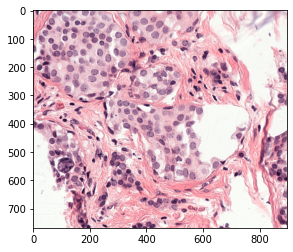

In [16]:
# Step 8: Convert extreme values back to OD space
# recreate the normalized image using reference mixing matrix 

Inorm1 = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm1[Inorm1>255] = 254
Inorm1 = np.reshape(Inorm1.T, (h, w, 3)).astype(np.uint8)  

# Separating H and E components

H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

plt.imsave("Results After Normlazation_RGB/ytma10_010704_malignant2.jpg", Inorm1)
imgplot = plt.imshow(Inorm1)
plt.show()

# Normalization For HSI Image

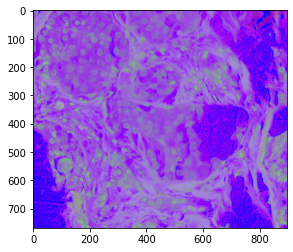

In [17]:
img1 = cv2.imread("Breast Cancer Cells/ytma10_010704_malignant2_ccd.tif")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
cv2.imshow('H and E stain',img1)
cv2.waitKey(0)
cv2.destroyAllWindows()
imgplot = plt.imshow(img1)
plt.show()

In [18]:
Io = 240       # Transmitted light intensity, Normalizing factor for image intensities
alpha = 1      #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
beta = 0.15    #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


In [19]:
# Step 1: Convert RGB to OD
# reference H&E OD matrix.

HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],                                  # default values. 
                  [0.4062, 0.5581]])
# reference maximum stain concentrations for H&E
maxCRef = np.array([1.9705, 1.0308])

# extract the height, width and num of channels of image
h, w, c = img1.shape

# reshape image to multiple rows and 3 columns.
#Num of rows depends on the image size (wxh)
img1 = img1.reshape((-1,3))


In [20]:
# calculate optical density
# OD = −log10(I)  
#OD = -np.log10(img1+0.004)  #Use this when reading images with skimage
#Adding 0.004 just to avoid log of zero. 

OD = -np.log10((img1.astype(np.float64)+1)/Io)    #Use this for opencv imread

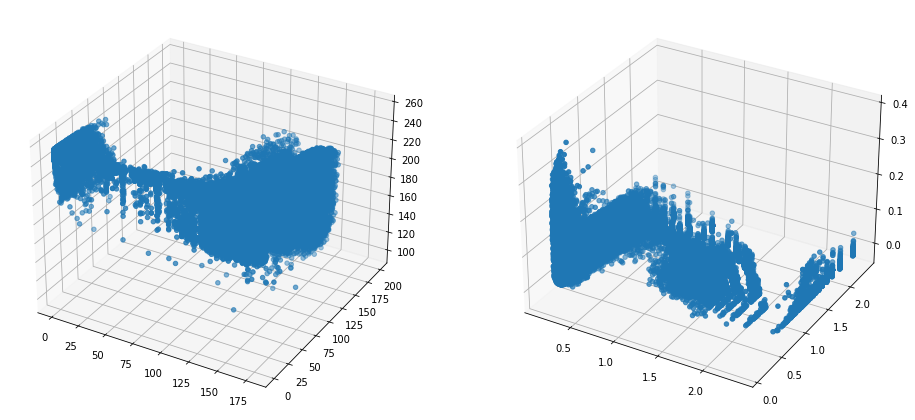

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(img1[:,0],img1[:,1],img1[:,2])
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(OD[:,0],OD[:,1],OD[:,2])
plt.show()

In [22]:
# Step 2: Remove data with OD intensity less than β 
# remove transparent pixels (clear region with no tissue)
ODhat = OD[~np.any(OD < beta, axis=1)]        #Returns an array where OD values are above beta

In [23]:
# Step 3: Calculate SVD on the OD tuples ######################
#Estimate covariance matrix of ODhat (transposed)
# and then compute eigen values & eigenvectors.
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

In [24]:
#Step 4: Create plane from the SVD directions with two largest values ######
# project on the plane spanned by the eigenvectors corresponding to the two 
# largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3]) #Dot product

In [25]:
# Step 6: Calculate angle of each point wrt the first SVD direction ########
#find the min and max vectors and project back to OD space
phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


# a heuristic to make the vector corresponding to hematoxylin first and the 
# one corresponding to eosin second
if vMin[0] > vMax[0]:    
    HE = np.array((vMin[:,0], vMax[:,0])).T
    
else:
    HE = np.array((vMax[:,0], vMin[:,0])).T


# rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T

# determine concentrations of the individual stains
C = np.linalg.lstsq(HE,Y, rcond=None)[0]

# normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])

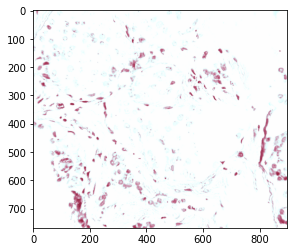

In [26]:
# Step 8: Convert extreme values back to OD space
# recreate the normalized image using reference mixing matrix 

Inorm2 = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm2[Inorm2>255] = 254
Inorm2 = np.reshape(Inorm2.T, (h, w, 3)).astype(np.uint8)  

# Separating H and E components

H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

plt.imsave("Results After Normalization_HSI/ytma10_010704_malignant2.jpg", Inorm2)
imgplot = plt.imshow(Inorm2)
plt.show()

# Normalization For  Lαβ Image

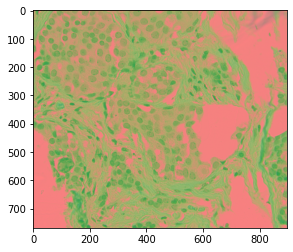

In [27]:
imglab = cv2.imread("Breast Cancer Cells/ytma10_010704_malignant2_ccd.tif")
imglab = cv2.cvtColor(imglab, cv2.COLOR_BGR2RGB)
imglab = cv2.cvtColor(imglab, cv2.COLOR_RGB2LAB)
cv2.imshow('H and E stain',imglab)
cv2.waitKey(0)
cv2.destroyAllWindows()
imgplot = plt.imshow(imglab)
plt.show()

In [28]:
Io = 240       # Transmitted light intensity, Normalizing factor for image intensities
alpha = 1      #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
beta = 0.15    #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


In [29]:
# Step 1: Convert RGB to OD
# reference H&E OD matrix.

HERef = np.array([[0.5626, 0.2159],
                  [0.7201, 0.8012],                                  # default values. 
                  [0.4062, 0.5581]])
# reference maximum stain concentrations for H&E
maxCRef = np.array([1.9705, 1.0308])

# extract the height, width and num of channels of image
h, w, c = imglab.shape

# reshape image to multiple rows and 3 columns.
#Num of rows depends on the image size (wxh)
imglab = imglab.reshape((-1,3))


In [30]:
# calculate optical density
# OD = −log10(I)  
#OD = -np.log10(imglab+0.004)  #Use this when reading images with skimage
#Adding 0.004 just to avoid log of zero. 

OD = -np.log10((imglab.astype(np.float64)+1)/Io)    #Use this for opencv imread

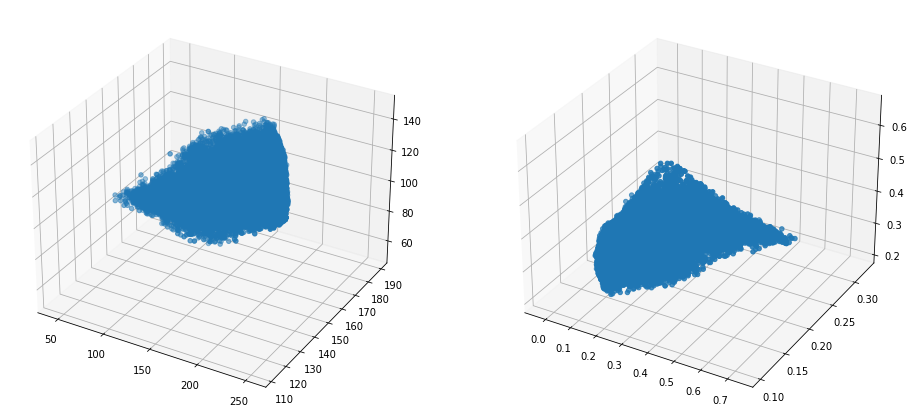

In [31]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(imglab[:,0],imglab[:,1],imglab[:,2])
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(OD[:,0],OD[:,1],OD[:,2])
plt.show()

In [32]:
# Step 2: Remove data with OD intensity less than β 
# remove transparent pixels (clear region with no tissue)
ODhat = OD[~np.any(OD < beta, axis=1)]        #Returns an array where OD values are above beta

In [33]:
# Step 3: Calculate SVD on the OD tuples ######################
#Estimate covariance matrix of ODhat (transposed)
# and then compute eigen values & eigenvectors.
eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

In [34]:
#Step 4: Create plane from the SVD directions with two largest values ######
# project on the plane spanned by the eigenvectors corresponding to the two 
# largest eigenvalues    
That = ODhat.dot(eigvecs[:,1:3]) #Dot product

In [35]:
# Step 6: Calculate angle of each point wrt the first SVD direction ########
#find the min and max vectors and project back to OD space
phi = np.arctan2(That[:,1],That[:,0])

minPhi = np.percentile(phi, alpha)
maxPhi = np.percentile(phi, 100-alpha)

vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


# a heuristic to make the vector corresponding to hematoxylin first and the 
# one corresponding to eosin second
if vMin[0] > vMax[0]:    
    HE = np.array((vMin[:,0], vMax[:,0])).T
    
else:
    HE = np.array((vMax[:,0], vMin[:,0])).T


# rows correspond to channels (RGB), columns to OD values
Y = np.reshape(OD, (-1, 3)).T

# determine concentrations of the individual stains
C = np.linalg.lstsq(HE,Y, rcond=None)[0]

# normalize stain concentrations
maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
tmp = np.divide(maxC,maxCRef)
C2 = np.divide(C,tmp[:, np.newaxis])

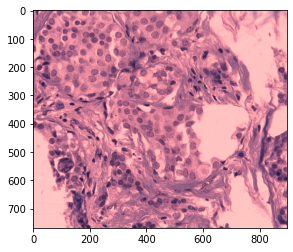

In [36]:
# Step 8: Convert extreme values back to OD space
# recreate the normalized image using reference mixing matrix 

Inorm3 = np.multiply(Io, np.exp(-HERef.dot(C2)))
Inorm3[Inorm3>255] = 254
Inorm3 = np.reshape(Inorm3.T, (h, w, 3)).astype(np.uint8)  

# Separating H and E components

H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
H[H>255] = 254
H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
E[E>255] = 254
E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

plt.imsave("Results After Normalization_lab/ytma10_010704_malignant2.jpg", Inorm3)
imgplot = plt.imshow(Inorm3)
plt.show()

# Now Let's Move on to Quantative Analysis of Different color forms.

# Extracting Ground Truth Image

In [37]:
imgd = cv2.imread("Breast Cancer Cells GroundTruth/ytma10_010704_malignant2.tif",0)
cv2.imshow('H and E stain',imgd)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [38]:
imgd.shape
rows, cols = (768, 896)
arr = [[0]*cols]*rows 

In [39]:
arr=imgd
pixval= np.array(arr)

In [40]:
flat_gt = pixval.flatten()                 # flattened the ground truth  just to reduce the computational stress.
print(flat_gt)

[0 0 0 ... 0 0 0]


# Now lets take the normalized image and find the W(i) value which is the average of (R, G, B) color intensities.

# RGB Analysis (NMI ~ Normalized Median Intensity)

In [41]:
Inorm1.shape

(768, 896, 3)

In [42]:
rows, cols = (768, 896)
r1 = np.array([[0]*cols]*rows)
g1 = np.array([[0]*cols]*rows)
b1 = np.array([[0]*cols]*rows)
r1,g1,b1= cv2.split(Inorm1)         # had split the rgb component of the rgb normalized image to find the W(i)
average_arr = np.add(r1,g1,b1)
average_arr=(average_arr)/3       # W(i) is basically the average of the 3 color component the r,g,b 
flat_rgb=average_arr.flatten()
size= int(rows*cols/5)  # just because the ground truth is almost dark so no need of 7,00,000 size of array so rounded it by 20
print(size)
print()
W_val_rgb= np.array([0]*size)     # created to put all the value of the roi of Normlaized image 
print(W_val_rgb)

137625

[0 0 0 ... 0 0 0]


In [43]:
for i in range (0,688128):
    if flat_gt[i]==255:
        W_val_rgb= np.append(flat_rgb,[flat_rgb[i]])  # putting the value of roi considering the 255 pixel intensity of ground truth 

In [44]:
print(W_val_rgb)  # all the pixel points on the normalized image with reference to the target image .

[56.         55.         48.33333333 ... 65.         41.33333333
 79.66666667]


In [45]:
print(W_val_rgb.shape)

(688129,)


![formula of nmi](NMI_formula.png)

In [46]:
W_val_rgb= np.sort(W_val_rgb)
medin= np.median(W_val_rgb)
max_value = np.max(W_val_rgb)
NMI_rgb= (medin/max_value)  
print(NMI_rgb)          # value of nmi of rgb

0.6901960784313725


# HSI Analysis (NMI ~ Normalized Median Intensity)

In [47]:
Inorm2.shape

(768, 896, 3)

In [48]:
rows, cols = (768, 896)
r2 = np.array([[0]*cols]*rows)
g2 = np.array([[0]*cols]*rows)
b2 = np.array([[0]*cols]*rows)
r2,g2,b2= cv2.split(Inorm2)         # had split the rgb component of the rgb normalized image to find the W(i)
average_hsi = np.add(r2,g2,b2)
average_hsi=(average_hsi)/3       # W(i) is basically the average of the 3 color component the r,g,b 
flat_hsi=average_hsi.flatten()
size= int(rows*cols/5)  # just because the ground truth is almost dark so no need of 7,00,000 size of array so rounded it by 20
print(size)
print()
W_val_hsi= np.array([0]*size)
print(W_val_hsi)

137625

[0 0 0 ... 0 0 0]


In [49]:
for i in range (0,688128):
    if flat_gt[i]==255:
        W_val_hsi= np.append(flat_hsi,[flat_hsi[i]])

In [50]:
print(W_val_hsi)  # all the pixel points on the normalized image with reference to the target image .

[84. 84. 84. ... 84. 84. 80.]


In [51]:
W_val_hsi= np.sort(W_val_hsi)
medin= np.median(W_val_hsi)
max_value = np.max(W_val_hsi)
NMI_hsi= (medin/max_value)
print(NMI_hsi)

0.9882352941176471


# Lαβ Analysis (NMI ~ Normalized Median Intensity)

In [52]:
Inorm3.shape

(768, 896, 3)

In [53]:
rows, cols = (768, 896)
r3 = np.array([[0]*cols]*rows)
g3 = np.array([[0]*cols]*rows)
b3 = np.array([[0]*cols]*rows)
r3,g3,b3= cv2.split(Inorm3)         # had split the rgb component of the rgb normalized image to find the W(i)
average_lab = np.add(r3,g3,b3)
average_lab=(average_lab)/3       # W(i) is basically the average of the 3 color component the r,g,b 
flat_lab=average_lab.flatten()
size= int(rows*cols/5)  # just because the ground truth is almost dark so no need of 7,00,000 size of array so rounded it by 20
# print(size)
# print()
W_val_lab= np.array([0]*size)
print(W_val_lab)

[0 0 0 ... 0 0 0]


In [54]:
for i in range (0,688128):
    if flat_gt[i]==255:
        W_val_lab= np.append(flat_lab,[flat_lab[i]])

In [55]:
print(W_val_lab)  # all the pixel points on the normalized image with reference to the target image .

[38.33333333 36.66666667 35.33333333 ... 53.66666667 30.33333333
 72.33333333]


In [56]:
W_val_lab= np.sort(W_val_lab)
medin= np.median(W_val_lab)
max_value = np.max(W_val_lab)
NMI_lab= (medin/max_value)
print(NMI_lab)

0.5137254901960784


# Results of NMI Calculation over the data set

|Image_Name||NMI_RGB||NMI_HSI||NMI_Lab|
|----||----||----||----|
|ytma10_010704_benign1_ccd.tif||0.9450980392156862||0.9882352941176471||0.6509803921568628|
|ytma10_010704_benign2_ccd.tif||0.9450980392156862||0.9882352941176471||0.9647058823529412|
|ytma10_010704_benign3_ccd.tif||0.8666666666666667||0.9882352941176471||0.7960784313725491|
|ytma10_010704_malignant1_ccd.tif||0.603921568627451||0.9882352941176471||0.5254901960784314|
|ytma10_010704_malignant2_ccd.tif||0.6901960784313725||0.9882352941176471||0.5137254901960784|